In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import monai
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from einops import rearrange
from oracle.models.base_transformer import VisionTransformer
from oracle.models.transformer_segmenter import SegmentationTransformer
from oracle.image_utils import convert_1d_index_to_2d, convert_scale_to_coords_in_full_res


c:\Users\David\.conda\envs\CandidateNet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
data_img_path = r'D:\Datasets\Decathlon\Task03_Liver\imagesTr\liver_16.nii.gz'
data_label_path = r'D:\Datasets\Decathlon\Task03_Liver\labelsTr\liver_16.nii.gz'
#data_img_path = "/media/david/T7/Decathlon/Dataset/Task03_Liver/imagesTr/liver_16.nii.gz"
#data_label_path = "/media/david/T7/Decathlon/Dataset/Task03_Liver/labelsTr/liver_16.nii.gz"

data_file = {'image': data_img_path, 'label': data_label_path}

In [4]:
load_im = monai.transforms.LoadImaged(keys=['image', 'label'])
chan_f = monai.transforms.EnsureChannelFirstD(keys=['image', "label"])
scale_intens = monai.transforms.ScaleIntensityRanged(keys='image', a_min=-21, a_max=189, b_min=0, b_max=1,clip=True)
to_t = monai.transforms.ToTensord(keys=["image", "label"])

data = to_t(scale_intens(chan_f(load_im(data_file))))

In [5]:
slice_max = 423

In [6]:
inputs = data['image'][:,:,:,slice_max].unsqueeze(0).to(device)
labels = data['label'][:,:,:,slice_max].unsqueeze(0).to(device)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def visualize_data(im, lab):
    plt.figure()
    if im is not None:
        plt.imshow(im.squeeze().cpu().numpy(), cmap='gray')
        plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)
    else:
        plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none')

In [43]:
def visualize_patches_scale(patches_scale_coords, n_scales, initial_patch_size, image_size, org_image=None, labels=None):
    colormap = ListedColormap(['silver', 'chocolate', 'blue', 'green', 'orange', 'magenta', 'red', 'pink'])
    full_image = torch.zeros(image_size[0] * image_size[1])
    for scale in range(n_scales):
        patch_size = initial_patch_size // 2**scale
        indx_curr_scale = patches_scale_coords[:, 0] == scale
        coords_at_curr_scale = patches_scale_coords[indx_curr_scale, 1]
        coords_at_org_scale = convert_scale_to_coords_in_full_res(coords_at_curr_scale, patch_size, image_size[0])
        full_image[coords_at_org_scale] = scale
    full_image = full_image.view(image_size[0], image_size[1])
    if org_image is not None:
        plt.imshow(org_image.squeeze().cpu().numpy(), cmap='gray')
    if labels is not None:
        plt.imshow(labels.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)
    plt.imshow(full_image.squeeze().cpu().numpy(), interpolation='none', alpha=0.5, cmap=colormap)


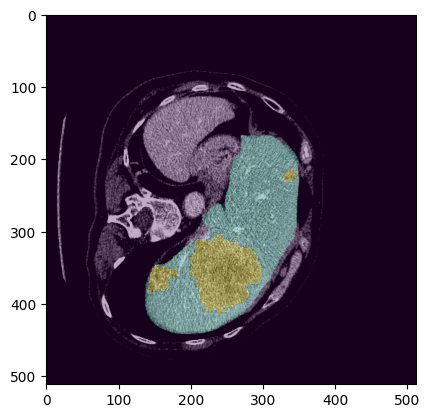

In [10]:
visualize_data(inputs, labels)

In [11]:
def create_oracle_labels(labels, patch_size): 
    max = F.max_pool2d(labels.float(), patch_size, stride=patch_size).to(torch.int32)
    min = F.max_pool2d(-labels.float(), patch_size, stride=patch_size).to(torch.int32)
    one_class = (max == -min)
    
    patch_groups_per_img = one_class.to(torch.uint8)
    
    return patch_groups_per_img.to(torch.long).squeeze(0)

torch.Size([1, 8, 8])
metatensor(49, device='cuda:0')
torch.Size([1, 16, 16])
metatensor(220, device='cuda:0')
torch.Size([1, 32, 32])
metatensor(940, device='cuda:0')
torch.Size([1, 64, 64])
metatensor(3917, device='cuda:0')
torch.Size([1, 128, 128])
metatensor(16047, device='cuda:0')
torch.Size([1, 256, 256])
metatensor(65082, device='cuda:0')


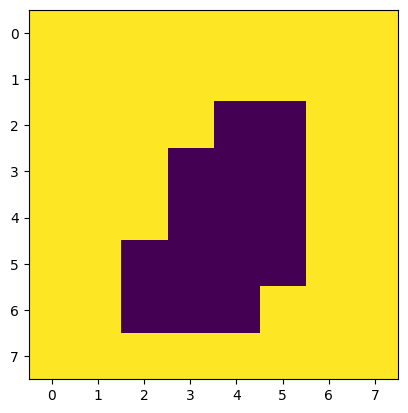

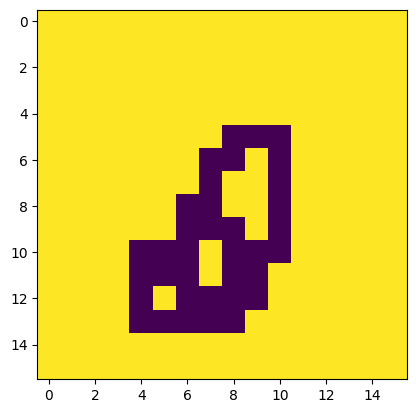

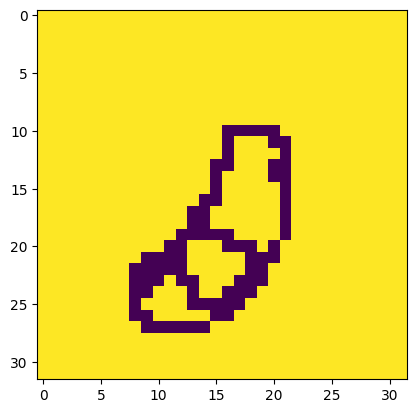

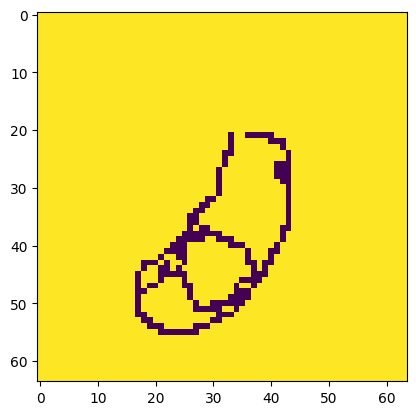

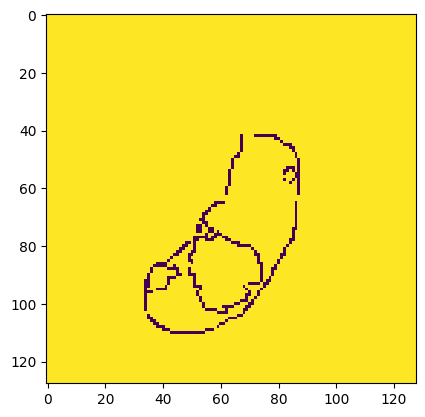

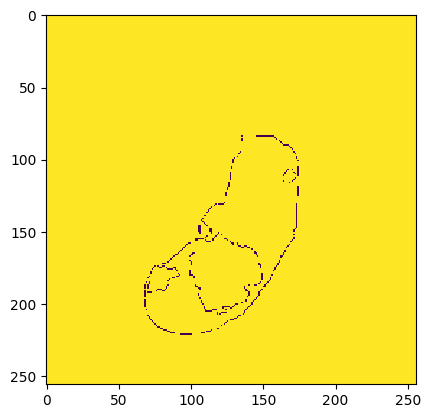

In [12]:
patch_sizes_used = [64, 32, 16, 8, 4, 2]
oracle_labels_multires = []
for ps in patch_sizes_used:
    ol = create_oracle_labels(labels, ps)
    visualize_data(None, ol)
    oracle_labels_multires.append(ol)
    print(ol.shape)
    print(ol.sum())


#oracle_labels = create_oracle_labels(labels, 64)
#visualize_data(inputs, oracle_labels)

In [45]:
d_encoder = 64
n_encoder_layers = 5
patch_size = 64
image_size = (inputs.shape[2], inputs.shape[3])
encoder = VisionTransformer(image_size=image_size,
                          patch_size=patch_size,
                          n_layers=n_encoder_layers,
                          d_model=d_encoder,
                          d_ff=256,
                          n_heads=4)
encoder = encoder.to(device)

decoder = SegmentationTransformer(image_size=image_size,
                          patch_size=patch_size,
                          n_layers=1,
                          d_model=64,
                          d_encoder=d_encoder,
                          d_ff=256,
                          n_heads=4)
decoder = decoder.to(device)

In [46]:
inputs = inputs.to(device)
enc_out, patches_scale_coords = encoder(inputs, oracle_labels_multires)
dec_out = decoder(enc_out, image_size, patches_scale_coords)

Current total number of tokens in layer 0: 64
Current number of tokens at scale 0 in layer 0: 64
Current total number of tokens in layer 1: 109
Current number of tokens at scale 0 in layer 1: 49
Current number of tokens at scale 1 in layer 1: 60
Current total number of tokens in layer 2: 217
Current number of tokens at scale 0 in layer 2: 49
Current number of tokens at scale 1 in layer 2: 24
Current number of tokens at scale 2 in layer 2: 144
Current total number of tokens in layer 3: 469
Current number of tokens at scale 0 in layer 3: 49
Current number of tokens at scale 1 in layer 3: 24
Current number of tokens at scale 2 in layer 3: 60
Current number of tokens at scale 3 in layer 3: 336
Current total number of tokens in layer 4: 1006
Current number of tokens at scale 0 in layer 4: 49
Current number of tokens at scale 1 in layer 4: 24
Current number of tokens at scale 2 in layer 4: 60
Current number of tokens at scale 3 in layer 4: 157
Current number of tokens at scale 4 in layer 4: 

In [47]:
patches_scale_coords[:,0].unique()

metatensor([0, 1, 2, 3, 4], device='cuda:0')

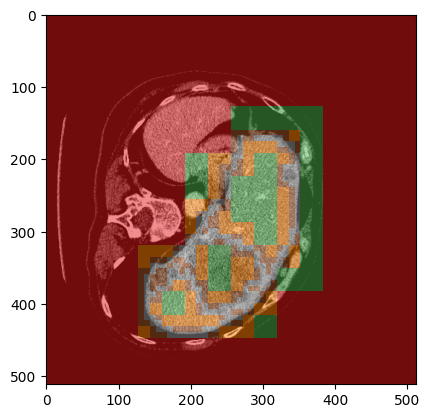

In [48]:
visualize_patches_scale(patches_scale_coords, n_encoder_layers, patch_size, image_size, inputs)